## 1 Setup

### 1.1 Import and configure libraries

In [43]:
# pip install --upgrade tensorflow after restart kernel

In [87]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import distance


# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style

# Text processing and cleaning
import unicodedata
import re

# Data modeling libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
import sklearn
from sklearn.metrics import f1_score


# Library versions
print("Numpy version:", np.__version__)
print("Scipy version:", sp.__version__)  # Commented out since spacy is not imported
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("TensorFlow version:", tf.__version__)
print("Scikit-learn version:", sklearn.__version__)

# Configure Numpy
# specify that the maximum width of printed lines should be 130 characters
# after 130 characters, it will continue in the next line
np.set_printoptions(linewidth=130)

# Configure Seaborn
sns.set_style("whitegrid")  # set white background with grid
sns.set_palette("deep")  # set color palette
sns.set_context("paper", font_scale=1.25)  # set font to scale 1.25, greater than default


Numpy version: 1.24.3
Scipy version: 1.11.4
Pandas version: 2.0.3
Matplotlib version: 3.7.4
Seaborn version: 0.12.2
TensorFlow version: 2.13.0
Scikit-learn version: 1.2.2


### 1.2 Constants and helper functions

In [45]:
INPUT_CSV = "/kaggle/input/bbc-text-classification-1-text-preprocessing/docs_stage_3_preprocessed.csv"

OUTPUT_DIM = 100  # Word embedding output dimension.


# Encoded class-labels from BBC Text classification - 1. Text preprocessing
cls_map = {'Business' : 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech' : 4}

### Helper functions

In [77]:
def show_n_vals(vec, n):
    """Helper function to print the first n values of a vector."""
    if vec is not None:
        return vec[:n]
    else:
        return None

def cosine_sim(gvec_index, word1, word2):
    """
    Function to compute cosine-similarity between
    two input words based on their GloVe vectors.
    """
    # Retrieve GloVe vectors for the input words
    vec1 = gvec_index.get(word1.lower())
    vec2 = gvec_index.get(word2.lower())

    if vec1 is not None and vec2 is not None:
        print(f"GloVe vector for '{word1}': {show_n_vals(vec1, 3)}")
        print(f"GloVe vector for '{word2}': {show_n_vals(vec2, 3)}")

        # Compute cosine similarity
        c_dist = distance.cosine(vec1, vec2) #Compute the Cosine distance between 1-D arrays.
        print(f"Cosine similarity between '{word1}' and '{word2}': {round(c_dist, 4)}")
        # 1 - c_dist is used to convert cosine distance to similarity
    else:
        print(f"One or both words not found in the GloVe index.")

# Example usage:
# cosine_sim(gvec_index, "Color", "Colour")


### 1.3 Load dataset

In [47]:
docs = pd.read_csv(INPUT_CSV)
docs.head(10)

,DocId,DocTextlen,DocText,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,...,PUNCT,SCONJ,SYM,VERB,X,INTJ,DocType,FileSize,FilePath,DocCat
0,P_361,3110,budget to set scene for election gordon brown ...,41,61,17.0,29.0,12.0,61,144,...,58,9.0,8.0,65,0.0,0.0,Politics,3132,/kaggle/input/bbc-full-text-document-classific...,0
1,P_245,3013,army chief in regiment decision military chief...,38,57,15.0,32.0,22.0,69,97,...,47,6.0,0.0,62,0.0,0.0,Politics,3018,/kaggle/input/bbc-full-text-document-classific...,0
2,P_141,3143,howard deny split over id card michael howard ...,31,43,12.0,47.0,14.0,52,109,...,74,15.0,0.0,94,1.0,0.0,Politics,3153,/kaggle/input/bbc-full-text-document-classific...,0
3,P_372,3074,observer to monitor uk election ministers will...,44,62,17.0,32.0,11.0,41,110,...,61,10.0,1.0,75,0.0,0.0,Politics,3082,/kaggle/input/bbc-full-text-document-classific...,0
4,P_333,2598,kilroy name election seat target ex - chat sho...,35,50,10.0,26.0,7.0,40,88,...,74,6.0,0.0,52,2.0,1.0,Politics,2604,/kaggle/input/bbc-full-text-document-classific...,0
5,P_276,2770,donor attack blair - brown ' feud ' the report...,39,43,12.0,30.0,16.0,46,95,...,60,8.0,1.0,62,0.0,0.0,Politics,2780,/kaggle/input/bbc-full-text-document-classific...,0
6,P_244,2882,research fear over kelly 's view scientist hav...,43,45,13.0,40.0,10.0,34,114,...,62,11.0,0.0,50,0.0,0.0,Politics,2889,/kaggle/input/bbc-full-text-document-classific...,0
7,P_175,2374,chancellor rally labour voter gordon brown hav...,28,54,13.0,14.0,20.0,40,108,...,60,0.0,3.0,49,0.0,0.0,Politics,2384,/kaggle/input/bbc-full-text-document-classific...,0
8,P_351,2977,fox attack blair 's tory ' lie ' tony blair li...,25,49,14.0,30.0,21.0,48,92,...,76,13.0,2.0,74,0.0,0.0,Politics,2990,/kaggle/input/bbc-full-text-document-classific...,0
9,P_265,2134,tory unveil quango blitz plan plan to abolish ...,35,31,7.0,31.0,12.0,27,85,...,50,3.0,1.0,50,0.0,0.0,Politics,2142,/kaggle/input/bbc-full-text-document-classific...,0


## 2 Exploratory Data Analysis

In [48]:
rows, cols = docs.shape
print(f"Dataset contains {rows} rows and {cols} columns.\n")
      
docs.info()

Dataset contains 2205 rows and 24 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DocId       2205 non-null   object 
 1   DocTextlen  2205 non-null   int64  
 2   DocText     2205 non-null   object 
 3   ADJ         2205 non-null   int64  
 4   ADP         2205 non-null   int64  
 5   ADV         2205 non-null   float64
 6   AUX         2205 non-null   float64
 7   CCONJ       2205 non-null   float64
 8   DET         2205 non-null   int64  
 9   NOUN        2205 non-null   int64  
 10  NUM         2205 non-null   float64
 11  PART        2205 non-null   float64
 12  PRON        2205 non-null   float64
 13  PROPN       2205 non-null   int64  
 14  PUNCT       2205 non-null   int64  
 15  SCONJ       2205 non-null   float64
 16  SYM         2205 non-null   float64
 17  VERB        2205 non-null   int64  
 18  X           2205 non-nul

#### Remarks

* Featurs `DocText` and `DocCat` is not missing any data.

> **Note**: For complete Exploratory Data Analysis refer PART 1: [BBC Text classification - 1. Text preprocessing][1].

[1]: https://www.kaggle.com/code/diaconumadalina/bbc-text-classification-1-text-preprocessing

## 3 Feature Engineering

### 3.1 Tokenization


To prepare text data for machine learning, it's essential to convert words into a numerical format. This process, known as integer encoding, assigns a unique integer to each word in the text. The Keras library provides a convenient tool called the `Tokenizer` API to perform this task.


Ref: [Tokenization and Text Data Preparation with TensorFlow & Keras][1]

[1]: https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

#### Tokenizer

In [49]:
tokenizer = Tokenizer(
    num_words = 5000, # Limit the number of words to consider based on frequency.
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # Define characters to filter out.
    oov_token = "<UNK>" # Out-of-vocabulary token to represent words not in the vocabulary.
)

tokenizer.fit_on_texts(docs["DocText"].values)

#### Word Index

In [50]:
word_index = tokenizer.word_index
vocabulary_size = len(word_index)

print("Words from vocabulary:", vocabulary_size)
print("\nFirst 15 words:\n")
for word, index in list(word_index.items())[:15]:
    print(f"{word}: {index}")

Words from vocabulary: 23375

First 15 words:

<UNK>: 1
the: 2
be: 3
to: 4
of: 5
and: 6
a: 7
in: 8
have: 9
say: 10
for: 11
that: 12
on: 13
it: 14
's: 15


In [51]:
# word_index.items()

#### Sequencing

In [52]:
en_docs = tokenizer.texts_to_sequences(docs["DocText"].values)

print("Sequence information:")
print("Data type:", type(en_docs))
print("Total count:", len(en_docs))
print("\nSample lengths and elements:")
_ = [print(f"Length: {len(seq)}, Elements: {seq[:5]}") for seq in en_docs[:3]]


Sequence information:
Data type: <class 'list'>
Total count: 2205

Sample lengths and elements:
Length: 555, Elements: [406, 4, 112, 1298, 11]
Length: 506, Elements: [3394, 235, 8, 3113, 269]
Length: 546, Elements: [310, 553, 1893, 64, 1254]


In [53]:
seq_lengths = [len(x) for x in en_docs]

# Get max training sequence length.
max_len = np.max(seq_lengths)
print("Longest sequence of length:", max_len)

# Get max training sequence length.
min_len = np.min(seq_lengths)
print("Shortest sequence of length:", min_len)


Longest sequence of length: 1091
Shortest sequence of length: 91


#### Distribution of sequence length

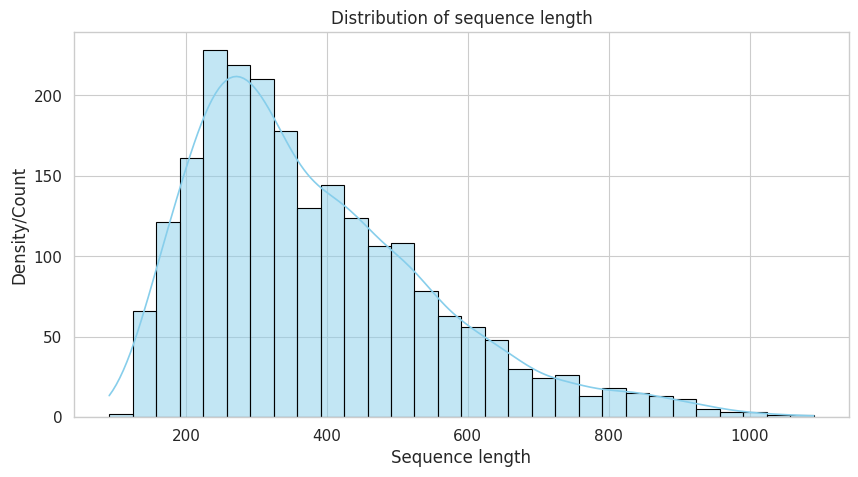

In [54]:
plt.figure(figsize=(10, 5))
sns.histplot(x=seq_lengths, kde=True, color='skyblue', edgecolor='black')
plt.xlabel("Sequence length")
plt.ylabel("Density/Count")
plt.title("Distribution of sequence length")
plt.show()


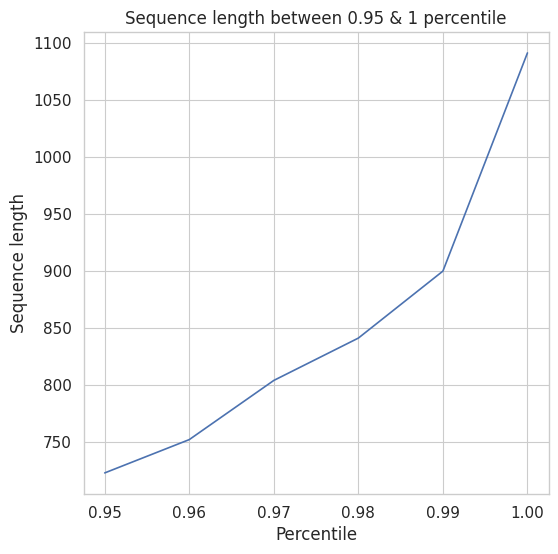

In [55]:
ll, hl = 0.95, 1
plt.figure(figsize=(6, 6))

x = np.arange(ll, hl, 0.01)
y = np.quantile(a=np.array(seq_lengths), q=x)
# x is an array of quantiles ranging from 0.95 to 1 with a step size of 0.01. 
# When you calculate the quantiles using np.quantile, the q parameter (quantiles) specifies the array of quantiles to compute.
sns.lineplot(x=x, y=y)
plt.title(f"Sequence length between {ll} & {hl} percentile")
plt.xlabel("Percentile")
plt.ylabel("Sequence length")

plt.show()

#### Remarks

~99% of documnents have sequence length less than 900.

### 3.2 Padding


In [56]:
seq_len = 900  # Adjust as needed

# Pad sequences
pad_docs = pad_sequences(en_docs, maxlen=seq_len, padding="post", truncating="post")

# Display padded sequences information
print("Padded sequences:")
print("Data type:", type(pad_docs), "Shape:", pad_docs.shape)
print("Sample values:")
print(pad_docs)

# This code uses the pad_sequences function from tensorflow.keras.preprocessing.sequence to pad sequences to a specified length (seq_len). 
# The padding="post" parameter ensures padding is added at the end of the sequences, and truncating="post" truncates sequences from the end if they exceed the specified length.

Padded sequences:
Data type: <class 'numpy.ndarray'> Shape: (2205, 900)
Sample values:
[[ 406    4  112 ...    0    0    0]
 [3394  235    8 ...    0    0    0]
 [ 310  553 1893 ...    0    0    0]
 ...
 [ 672  757 1079 ...    0    0    0]
 [ 115  952  202 ...    0    0    0]
 [  52  404 1717 ...    0    0    0]]


### 3.3 GloVe Vectors

Load vector representation of words


In [57]:
%%time

# load the whole embedding.

def load_glove_vectors(file_path):
    with open(file_path, encoding="utf8") as txt_f:
        for line in txt_f:
            columns = line.split()
            wrd = columns[0]
            vec = np.array(columns[1:], dtype="float32")
            yield wrd, vec

# Provide the path to your GloVe file
GLOVE_TXT = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'  # Adjust the file path and dimensions
gvec_index = dict(load_glove_vectors(GLOVE_TXT))


CPU times: user 3.59 s, sys: 134 ms, total: 3.72 s
Wall time: 3.71 s


In [58]:
list(gvec_index.items())[0]
# gvec_index.keys()
# gvec_index

('the',
 array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01, -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04,
        -6.5660e-01,  2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,  1.1658e-02,  1.0204e-01, -1.2792e-01,
        -8.4430e-01, -1.2181e-01, -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01, -1.8823e+00, -7.6746e-01,
         9.9051e-02, -4.2125e-01, -1.9526e-01,  4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,  7.4449e-03,
         1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02, -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01], dtype=float32))

In [59]:
def show_n_vals(vector, n=3):
    return f"{vector[:n]} ... {vector[-n:]}"

print("Total number of words in GloVe index:", len(gvec_index))
print("Sample word vectors:")

table = PrettyTable(["Word", "Pre-trained Vectors"])
# table.align["Word"] = "l"
# table.align["Pre-trained Vectors"] = "l"

# Display a subset of words and their vectors
for word, vector in list(gvec_index.items())[:5]:
    table.add_row([word, show_n_vals(vector)])

print(table)


Total number of words in GloVe index: 400000
Sample word vectors:
+------+---------------------------------------------------------------------+
| Word |                         Pre-trained Vectors                         |
+------+---------------------------------------------------------------------+
| the  |    [ 0.418    0.24968 -0.41242] ... [-0.18411 -0.11514 -0.78581]    |
|  ,   | [ 0.013441  0.23682  -0.16899 ] ... [-0.56657   0.044691  0.30392 ] |
|  .   |   [ 0.15164  0.30177 -0.16763] ... [-0.35652   0.016413  0.10216 ]  |
|  of  |   [ 0.70853  0.57088 -0.4716 ] ... [-0.22562  -0.093918 -0.80375 ]  |
|  to  | [ 0.68047  -0.039263  0.30186 ] ... [-0.073297 -0.064699 -0.26044 ] |
+------+---------------------------------------------------------------------+


### Missing words


In [60]:
word_set = set(word_index.keys())
gvec_set = set(gvec_index.keys())

missing_words_set = word_set - gvec_set
misc = len(missing_words_set)
misp = round(misc / len(word_set) * 100, 1)

print(f"{misc}, {misp}% words in our vocabulary do not have GloVe vectors.")


1311, 5.6% words in our vocabulary do not have GloVe vectors.


### Load weights


In [61]:
# OUTPUT_DIM = 100  #  the output dimensionality of word vectors 
# All zero-valued vector
zero_vec = np.zeros(OUTPUT_DIM)

# Create a list of word vectors using list comprehension
weights = [gvec_index.get(word, zero_vec).tolist() for word in word_index.keys()]

# Prepend a zero vector for <PAD>
weights = [zero_vec.tolist()] + weights

# Ensure all word vectors have the same dimensionality
max_len = max(len(vec) for vec in weights) #It calculates the maximum length among all word vectors in weights 
weights = [vec + [0.0] * (max_len - len(vec)) for vec in weights] #and pads shorter vectors with zeros to make them have the same dimensionality as the maximum length.

# Convert the list of lists to a TensorFlow constant tensor
weights = tf.constant(weights, dtype=tf.float32)

print("Weights datatype:", weights.dtype)
print("Weights shape:", weights.shape)

# weight matrix has 23,376 rows and 100 columns. Each row corresponds to a word in your vocabulary, and each column represents a feature in the word vectors with a dimensionality of 100.

Weights datatype: <dtype: 'float32'>
Weights shape: (23376, 100)


### 3.4 Cosine Similarity


1. GloVe provides word vectors for both American English and British English words.

2. All words in GloVe embeddings are in lowercase.

3. Cosine similarity ranges between 0 and 1.

4. Zero indicates the least distance, meaning the highest similarity, while one indicates the maximum distance, implying the lowest similarity.


#### Example 1: American English vs British English (Color vs Colour)

In [75]:
cosine_sim(gvec_index, "Color", "Colour")

GloVe vector for 'Color': [-0.86832  0.98449 -0.24756]
GloVe vector for 'Colour': [-0.58068  0.90569 -0.73373]
Cosine similarity between 'Color' and 'Colour': 0.1089


#### Example 2: Dissimilar words (Pasta vs Lithium)

In [76]:
cosine_sim(gvec_index, "Pasta", "Lithium")

GloVe vector for 'Pasta': [ 0.79324 -0.26557 -1.1389 ]
GloVe vector for 'Lithium': [0.78971 0.58855 1.4308 ]
Cosine similarity between 'Pasta' and 'Lithium': 0.651


### 3.5 POS features

Calculate the frequency of each part-of-speech category in a given document and integrate these counts alongside padded sequences as input for a neural network.

In [85]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DocId       2205 non-null   object 
 1   DocTextlen  2205 non-null   int64  
 2   DocText     2205 non-null   object 
 3   ADJ         2205 non-null   int64  
 4   ADP         2205 non-null   int64  
 5   ADV         2205 non-null   float64
 6   AUX         2205 non-null   float64
 7   CCONJ       2205 non-null   float64
 8   DET         2205 non-null   int64  
 9   NOUN        2205 non-null   int64  
 10  NUM         2205 non-null   float64
 11  PART        2205 non-null   float64
 12  PRON        2205 non-null   float64
 13  PROPN       2205 non-null   int64  
 14  PUNCT       2205 non-null   int64  
 15  SCONJ       2205 non-null   float64
 16  SYM         2205 non-null   float64
 17  VERB        2205 non-null   int64  
 18  X           2205 non-null   float64
 19  INTJ        2205 non-null  

In [83]:
docs.iloc[:, 3:18].astype("int32").head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB
0,41,61,17,29,12,61,144,11,21,24,47,58,9,8,65
1,38,57,15,32,22,69,97,6,17,26,59,47,6,0,62
2,31,43,12,47,14,52,109,0,23,47,60,74,15,0,94
3,44,62,17,32,11,41,110,15,21,21,43,61,10,1,75
4,35,50,10,26,7,40,88,7,20,32,88,74,6,0,52


## 4 Custom Callbacks

### 4.1 Callback #1: `PerformanceMetrics`

Create a callback in Python using Keras that calculates and prints the micro F1 score for the validation dataset during the training of a neural network.

In [89]:
class PerformanceMetrics(callbacks.Callback):
    def __init__(self, X_test, y_test):
        super(PerformanceMetrics, self).__init__()
        self.X_test = X_test
        self.y_test = y_test

    def calculate_micro_f1(self):
        # Predict on the validation data
        cl_prob = self.model.predict(self.X_test)
        y_pred = np.argmax(cl_prob, axis=1)

        # Calculate micro F1 score
        f1_scr = f1_score(self.y_test, y_pred, average="micro")
        return f1_scr

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        # Calculate micro F1 score
        f1_scr = self.calculate_micro_f1()

        # Print the F1 score
        print(f"Epoch {epoch + 1} - Validation Micro F1 Score: {round(f1_scr, 4)}") # When reporting progress or results to users, it's common to start counting from 1 (e.g., "Epoch 1" instead of "Epoch 0")

# Example usage:
# Assuming you have a model (model), validation data (X_val, y_val), and a fitting process
# metrics_callback = PerformanceMetrics(X_test=X_val, y_test=y_val)
# model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[metrics_callback])

### 4.2 Callback #2: `SaveBetterModel`

A callback is implemented to save the model after each training epoch, but only if the validation accuracy has improved compared to the previous epoch. This ensures that only models with better validation performance are saved during the training process.


In [90]:
class SaveBetterModel(callbacks.ModelCheckpoint):
    def __init__(self, **kwargs):
        super().__init__(
            monitor="val_accuracy",
            verbose=2,
            save_best_only=True,
            mode="max",
            **kwargs,
        )

    def on_epoch_end(self, epoch, logs=None):
        # To stop propagation of callbacks.
        if self.model.stop_training:
            return

        super().on_epoch_end(epoch, logs) # The epoch and logs parameters provide information about the current training state.

### 4.3 Callback #3: `TerminateWhenNaN`

In [96]:
class TerminateWhenNaN(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check if training should be stopped by a previous callback.
        if self.model.stop_training:
            return

        # Retrieve the loss value from the training logs.
        loss = logs.get("loss")

        # Check if the loss is invalid (NaN or infinity).
        if (loss is not None) and (np.isnan(loss) or np.isinf(loss)): #The overall expression is using negation to check for the absence of a valid loss value.
            print(f"Training terminated at epoch {epoch}: Invalid loss value ({loss}).")

            # Inform the training loop to stop further epochs.
            self.model.stop_training = True


### 4.4 Callback #4: `DecayLearningRate`

1. If the accuracy on the validation dataset decreases in the current epoch compared to the previous epoch, decrease the learning rate by 10%.
2. Every third epoch, decrease the learning rate by 5%.

In [97]:
class DecayLearningRate(callbacks.Callback):
    def __init__(self):
        self.prev_val_acc = 0  # previous validation accuracy.

    def get_learning_rate(self):
        return float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

    def set_learning_rate(self, new_lr):
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            return

        curr_val_acc = logs.get("val_accuracy")
        lr = self.get_learning_rate()

        if curr_val_acc < self.prev_val_acc:
            reduction_percentage = 10
        elif (epoch + 1) % 3 == 0:
            reduction_percentage = 5
        else:
            reduction_percentage = 0

        if reduction_percentage > 0:
            new_lr = lr * (1 - reduction_percentage / 100)
            self.set_learning_rate(new_lr)
            print(f"Reducing learning rate by {reduction_percentage}%. New learning rate: {round(new_lr, 6)}")

        self.prev_val_acc = curr_val_acc


### 4.5 Callback #5: `TerminateOnNoChange`

**Early stopping** is a training optimization technique that automatically halts the training of a machine learning model when its performance on a validation set stops improving. This prevents overfitting and helps find the best model without unnecessary computational costs.

In [99]:
class TerminateOnNoChange(callbacks.EarlyStopping):
    def __init__(self, epochs):
        super().__init__(
            monitor="val_accuracy", 
            patience=epochs, 
            verbose=2, 
            mode="max")

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        super().on_epoch_end(epoch, logs)

## 5 Training Setup

Guidance from:

https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

https://www.kaggle.com/code/dheemanthbhat/bbc-text-classification-part-2-modeling

https://nlp.stanford.edu/projects/glove/

https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

https://www.tensorflow.org/guide/keras/writing_your_own_callbacks

https://keras.io/api/callbacks/early_stopping/